In [1]:
# ======= BƯỚC 1: Import các thư viện cần thiết =======
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
# ======= BƯỚC 2: Khởi tạo Spark Session =======
spark = SparkSession.builder.appName("LogisticRegression").getOrCreate()

In [24]:
# ======= BƯỚC 3: Load dữ liệu =======
df = spark.read.csv(r"D:/Năm 3 - HK2/Dữ liệu lớn/DeepStroke/data/processed_data/preprocess.csv", header=True, inferSchema=True)

In [25]:
# ======= BƯỚC 4: Tiền xử lý =======
# Cột mục tiêu
target_col = "HadStroke"
feature_cols = [col for col in df.columns if col != target_col]

# Chia dữ liệu thành tập train/test
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [26]:
# ======= BƯỚC 5: Xây dựng pipeline =======
# Tạo pipeline với các bước xử lý dữ liệu và mô hình
logistic_regression = LogisticRegression(labelCol=target_col, featuresCol="scaled_features")
pipeline = Pipeline(stages=indexers + [encoder, assembler, scaler, logistic_regression])

# Huấn luyện mô hình trên dữ liệu huấn luyện
model = pipeline.fit(train_data)

In [27]:
# ======= BƯỚC 6: Dự đoán trên tập kiểm tra =======
predictions = model.transform(test_data)

In [28]:
# ======= BƯỚC 7: Đánh giá mô hình =======
# Đánh giá AUC (đúng với BinaryClassificationEvaluator)
evaluator = BinaryClassificationEvaluator(labelCol=target_col, rawPredictionCol="prediction")
auc = evaluator.evaluate(predictions)

# Đánh giá độ chính xác (accuracy) - dùng MulticlassClassificationEvaluator
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)

# Đánh giá Precision và Recall - Sử dụng MulticlassClassificationEvaluator
precision_evaluator = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)

recall_evaluator = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)

# Đánh giá F1-score
f1_evaluator = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)

# In kết quả đánh giá
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")


AUC: 0.7464
Accuracy: 0.7464
Precision: 0.7464
Recall: 0.7464
F1-score: 0.7464


<Figure size 1000x600 with 0 Axes>

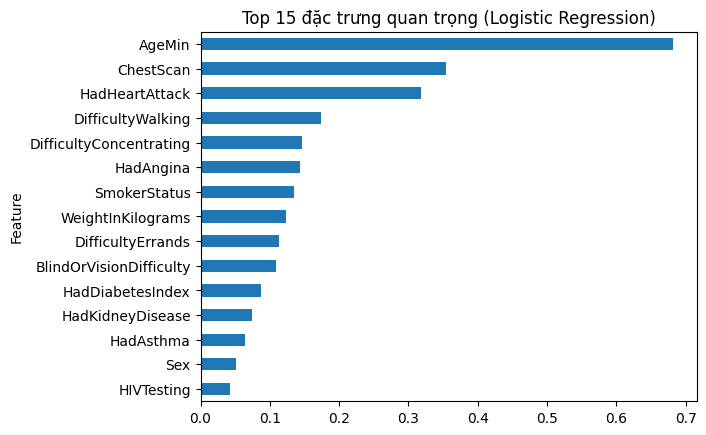

Bảng các đặc trưng quan trọng:
                      Feature    Weight
28                     AgeMin  0.681487
21                  ChestScan  0.354247
5              HadHeartAttack  0.317958
16          DifficultyWalking  0.174260
15    DifficultyConcentrating  0.146155
6                   HadAngina  0.143853
19               SmokerStatus  0.134262
3           WeightInKilograms  0.123415
18          DifficultyErrands  0.112922
14    BlindOrVisionDifficulty  0.108929
31           HadDiabetesIndex  0.087171
11           HadKidneyDisease  0.074404
7                   HadAsthma  0.063704
0                         Sex  0.051211
23                 HIVTesting  0.043218
13        DeafOrHardOfHearing  0.030503
10      HadDepressiveDisorder  0.028594
20            ECigaretteUsage  0.027118
17  DifficultyDressingBathing  0.024334
25              PneumoVaxEver  0.020722
26           HighRiskLastYear  0.017755
12               HadArthritis  0.005717
8               HadSkinCancer  0.004410
9        

In [29]:
# ======= BƯỚC 8: Hiển thị trọng số đặc trưng =======
# Lấy thông số của Logistic Regression (sử dụng coefs từ mô hình)
log_reg_model = model.stages[-1]  # Logistic Regression là model cuối cùng trong pipeline
weights = log_reg_model.coefficients
intercept = log_reg_model.intercept

# Chuyển thành pandas Series để dễ dàng hiển thị
weights_df = pd.DataFrame({
    'Feature': feature_cols,
    'Weight': weights.toArray()
})

# Sắp xếp và hiển thị các đặc trưng theo trọng số
weights_df = weights_df.sort_values(by="Weight", ascending=False)
plt.figure(figsize=(10, 6))
weights_df.head(15).plot(kind='barh', x='Feature', y='Weight', legend=False)
plt.title("Top 15 đặc trưng quan trọng (Logistic Regression)")
plt.gca().invert_yaxis()  # Đảo ngược trục y để đặc trưng quan trọng nhất ở trên cùng
plt.show()

# Hiển thị bảng giá trị các đặc trưng quan trọng
print("Bảng các đặc trưng quan trọng:")
print(weights_df)

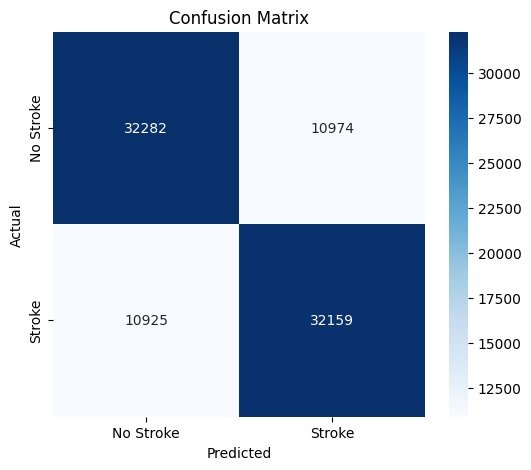

In [ ]:
# ======= BƯỚC 9: Hiển thị confusion matrix =======
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Chuyển kết quả dự đoán và nhãn thực tế từ PySpark sang Pandas DataFrame
y_true = predictions.select(target_col).toPandas()
y_pred = predictions.select("prediction").toPandas()

# Tính confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ confusion matrix dưới dạng heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Stroke", "Stroke"], yticklabels=["No Stroke", "Stroke"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
